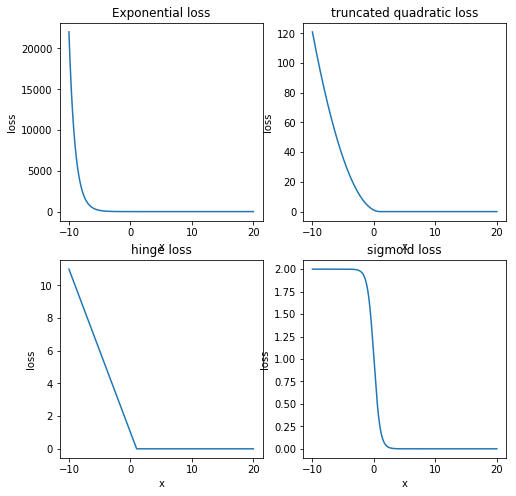

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline



x = np.arange(-10,20,.01)

def exp_loss(x):
    return np.exp(-x)
y1 = np.vectorize(exp_loss)

def truncated_loss(x):
    if x>1 :
        return 0
    if x<=1 :
        return (1-x)**2
y2 = np.vectorize(truncated_loss)


def hinge_loss(x):
    if x>1 :
        return 0
    if x<=1 :
        return (1-x)
y3 = np.vectorize(hinge_loss)

def sigmoid_loss(x):
    return (1-np.tanh(x))
y4 = np.vectorize(sigmoid_loss)

plt.figure(1,figsize=(8,8))

ax = plt.subplot(221)
ax.plot(x, y1(x))
ax.set(xlabel='x', ylabel='loss',
       title='Exponential loss')

ax = plt.subplot(222)
ax.plot(x, y2(x))
ax.set(xlabel='x', ylabel='loss',
       title='truncated quadratic loss')

ax = plt.subplot(223)
ax.plot(x, y3(x))
ax.set(xlabel='x', ylabel='loss',
       title='hinge loss')

ax = plt.subplot(224)
ax.plot(x, y4(x))
ax.set(xlabel='x', ylabel='loss',
       title='sigmoid loss')

plt.show()

apply kernel PCA with quadratic kernel using sklearn.  Plot the principle components, then reconstruct X with only the first PC and plot it with the data X.

In [2]:
from matplotlib import pyplot as plt
import numpy as np

In [3]:
n = 100
X = np.random.normal(0,.5,size=(n,2))
Theta = 2.*np.pi*np.arange(n)/n
X[:,0] += 3.*np.sin(Theta)
X[:,1] += 3.*np.cos(Theta)

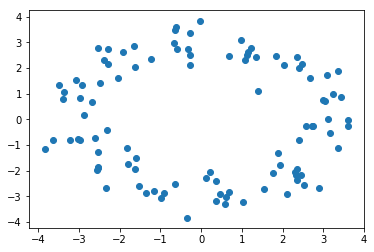

In [4]:
plt.scatter(X[:n,0],X[:n,1])
plt.show()

In [5]:

from sklearn.decomposition import PCA
from sklearn.datasets import make_circles
from sklearn.decomposition import PCA,KernelPCA
X = X[:n,:]
pca = PCA()
kernel_pca = KernelPCA(n_components = 2, kernel = 'poly',degree = 2, fit_inverse_transform = True)


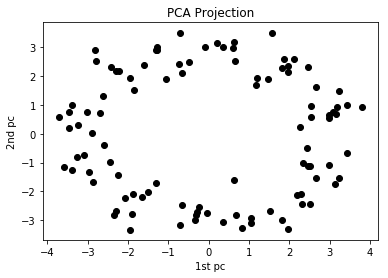

In [8]:
Xkpca = kernel_pca.fit_transform(X) 
Xpca = pca.fit_transform(X)
 
plt.scatter(Xpca[:,0],Xpca[:,1],c = 'black') 
plt.title("PCA Projection")
plt.xlabel("1st pc")
plt.ylabel("2nd pc")
plt.show()


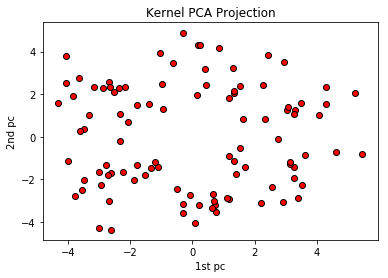

In [9]:
plt.scatter(Xkpca[:,0],Xkpca[:,1],c = 'red',edgecolor = 'k')
plt.title("Kernel PCA Projection")
plt.xlabel("1st pc")
plt.ylabel("2nd pc")
plt.show()

Below is an import of a reuters data.  Construct a response variable with has three categories, if the topic is 'earn', 'acq', or another category.  Import all of the data and construct a kernel matrix between the documents based on the overlap of words in the body of the document (you can choose the notion of similarity, but try to make it make sense).  Try including into your kernel the overlap between the places.  Use sklearn svm.SVC with this as the precomputed kernel to fit on the data in the TRAIN split and predict on the TEST split.  Plot  ROC and PR curves for predicting 'earn' (versus everything else) and compare several different versions of the kernel.

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles
from lxml import html, etree
import nltk
# nltk.download()
# Download Corpora -> stopwords, Models -> punkt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import os

from sklearn.svm import SVC
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
reu = html.parse("reuters/reut2-000.sgm") #You will have to do this for all sgm files here

In [12]:
import nltk
# Download Corpora -> stopwords, Models -> punkt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [13]:
def parse_reu(reu):
    """Parses the etree object and returns a list of dictionary of reuters attr
    Output: {'topics': the topic of the article, 'places': where it is located, 
        'split': training/test split, 'body':the text of the article as a set of words with stopwords removed}
    """
    root= reu.getroot()
    articles = root.body.getchildren()
    stop_words = set(stopwords.words('english'))
    reu_pl = []
    for a in articles:
        reu_parse = {}  
        if a.attrib['topics'] != 'YES':
            next
        topics = a.find('topics').findall('d')
        if topics:
            reu_parse['topics'] = [t.text for t in topics]
        else:
            reu_parse['topics'] = []
        places = a.find('places').findall('d')
        if places:
            reu_parse['places'] = [t.text for t in places]
        else:
            reu_parse["places"] = []
        reu_parse['split'] = a.attrib['lewissplit']
        rtxt = a.find('text')
        word_tokens = word_tokenize(rtxt.text_content())
        filtered_sentence = set([w.lower() for w in word_tokens if not w in stop_words])
        reu_parse['body'] = filtered_sentence
        reu_pl.append(reu_parse)
    return reu_pl

In [14]:
doc = []
file = ["%.2d" % i for i in range(22)] 
for i in file:
    reu = html.parse("reuters/reut2-0%s.sgm"%i) 
    reu_pl = parse_reu(reu)
    doc += reu_pl
    
train = [x for x in doc if x['split'] == 'TRAIN']
test = [x for x in doc if x['split'] == 'TEST']

In [15]:
def assign_y (db):
    topic = [x['topics'] for x in db] 
    y = []
    for x in topic:
        if 'earn' in x:
            y.append('earn')
        elif 'aqc' in x: 
            y.append('aqc')
        else: 
            y.append('another')
    return y

train_response = assign_y(train)
test_response = assign_y(test)

n_tr = len(train)
n_te = len(test)

In [16]:
y_modified = []
for x in test_response:
    if x == 'earn': 
        y_modified.append(1)
    else: 
        y_modified.append(0)

In [17]:
def tfid_transform(data_name, data_number):
    if data_number == 1:
        data = [" ".join(x[data_name]) for x in train] + [" ".join(x[data_name]) for x in test]
    else:
        data = [" ".join(list(x['body'])+x['places']) for x in train] + [" ".join(list(x['body'])+x['places']) for x in test]
    tfid_data = TfidfVectorizer().fit_transform(data)
    kernel_data = (tfid_data * tfid_data.T).A
    kernel_train = kernel_data[:n_tr,:n_tr]
    kernel_test = kernel_data[n_tr:,:n_tr]
    return kernel_train, kernel_test

def svc_kernel(data_name, data_number):
    kernel_train, kernel_test = tfid_transform(data_name, data_number)
    svc_kernel = SVC(kernel = 'precomputed',probability = True) 
    svc_kernel.fit(kernel_train, train_response)
    predict = svc_kernel.predict_proba(kernel_test)
    return predict

def line_kernel (data_name, data_number):
    predict = svc_kernel(data_name, data_number)
    data = predict[:,1]
    fpr, tpr, _ = metrics.roc_curve(y_modified, data)
    precision, recall, _ = metrics.precision_recall_curve(y_modified,data)
    return fpr,tpr, precision, recall

In [18]:
fpr1, tpr1, precision1, recall1 = line_kernel ("body",1)
fpr2, tpr2, precision2, recall2 = line_kernel ("places",1)
fpr3, tpr3, precision3, recall3 = line_kernel ("body and places",0)

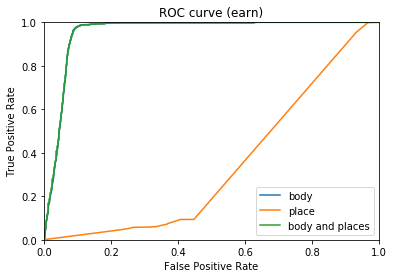

In [19]:
plt.title('ROC curve (earn)')
plt.plot(fpr1, tpr1, label = 'body')
plt.plot(fpr2, tpr2, label = 'place')
plt.plot(fpr3, tpr3, label = 'body and places')
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

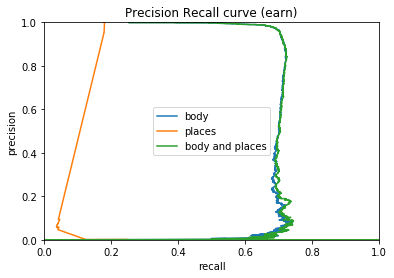

In [20]:
plt.title('Precision Recall curve (earn)')
plt.plot(precision1, recall1, label = 'body')
plt.plot(precision2, recall2, label = 'places')
plt.plot(precision3, recall3, label = 'body and places')
plt.ylabel('precision')
plt.xlabel('recall')
plt.legend(loc = 'center')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

Thus kernel with respect to body is much better than kernel with respect to places. Body contribute the most for classification, since once we combine body and places, the combined kernel is almost solely based on body.

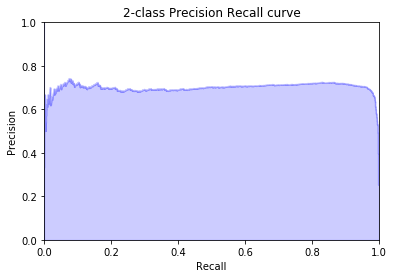

In [21]:
plt.title('2-class Precision Recall curve')
plt.step(recall1,precision1 ,color = 'b',alpha = .2,where = 'post')
plt.fill_between(recall1,precision1,step= 'post', alpha=.2, color = 'b')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()